##plot the density curve of KNN and LOF

In [ ]:
from pyod.models.knn import KNN
from pyod.models.lof import LOF
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import *
import pickle
import numpy as np
import torch
import PIL.Image
import dnnlib
from torch_utils import distributed as dist
from training import dataset
from torch_utils import misc
import random

In [2]:
def plot_density_with_idx(feature,idx_list,score_type='knn',num_layer=4):
    if score_type=='knn':
        total_knn = KNN(method='mean')
        total_knn.fit(feature.cpu().numpy())
        total_score = total_knn.decision_scores_
    else:
        total_LOF = LOF()
        total_LOF.fit(feature.cpu().numpy())
        total_score = total_LOF.decision_scores_
    
    num_data = int(len(feature)/num_layer)
    for i in range(num_layer):
        current_idx = idx_list[i*num_data:(i+1)*num_data]
        current_score = total_score[current_idx]
        cur_data = pd.Series(current_score)
        cur_data.plot(kind = 'kde',label = 'rank{}'.format(i), linewidth=4)
        plt.legend(fontsize=14)
    plt.tick_params(axis='both', labelsize=16)
    plt.ylabel('Density', fontsize=21)
    if score_type=='knn':
        plt.xlabel('AvgkNN', fontsize=21)
    else:
        plt.xlabel('LOF', fontsize=21)

In [3]:
class Detector:
    def __init__(self, feature_dim):
        self.feature_dim = feature_dim

    def __call__(self, x): # NCHW, uint8, 3 channels => NC, float32
        raise NotImplementedError # to be overridden by subclass

class InceptionV3Detector(Detector):
    def __init__(self):
        super().__init__(feature_dim=2048)
        url = 'https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/metrics/inception-2015-12-05.pkl'
        with dnnlib.util.open_url(url, verbose=False) as f:
            self.model = pickle.load(f)

    def __call__(self, x):
        return self.model.to(x.device)(x, return_features=True)

class DINOv2Detector(Detector):
    def __init__(self, resize_mode='torch'):
        super().__init__(feature_dim=1024)
        self.resize_mode = resize_mode
        import warnings
        warnings.filterwarnings('ignore', 'xFormers is not available')
        torch.hub.set_dir(dnnlib.make_cache_dir_path('torch_hub'))
        self.model = torch.hub.load('facebookresearch/dinov2:main', 'dinov2_vitl14', trust_repo=True, verbose=False, skip_validation=True)
        self.model.eval().requires_grad_(False)

    def __call__(self, x):
        # Resize images.
        if self.resize_mode == 'pil': # Slow reference implementation that matches the original dgm-eval codebase exactly.
            device = x.device
            x = x.to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()
            x = np.stack([np.uint8(PIL.Image.fromarray(xx, 'RGB').resize((224, 224), PIL.Image.Resampling.BICUBIC)) for xx in x])
            x = torch.from_numpy(x).permute(0, 3, 1, 2).to(device)
        elif self.resize_mode == 'torch': # Fast practical implementation that yields almost the same results.
            x = torch.nn.functional.interpolate(x.to(torch.float32), size=(224, 224), mode='bicubic', antialias=True)
        else:
            raise ValueError(f'Invalid resize mode "{self.resize_mode}"')

        # Adjust dynamic range.
        x = x.to(torch.float32) / 255
        x = x - misc.const_like(x, [0.485, 0.456, 0.406]).reshape(1, -1, 1, 1)
        x = x / misc.const_like(x, [0.229, 0.224, 0.225]).reshape(1, -1, 1, 1)

        # Run DINOv2 model.
        return self.model.to(x.device)(x)

In [4]:
metric_specs = {
    'fid':          dnnlib.EasyDict(detector_kwargs=dnnlib.EasyDict(class_name=InceptionV3Detector)),
    'fd_dinov2':    dnnlib.EasyDict(detector_kwargs=dnnlib.EasyDict(class_name=DINOv2Detector)),
}

_detector_cache = dict()

def get_detector(metric, verbose=True):
    # Lookup from cache.
    if metric in _detector_cache:
        return _detector_cache[metric]

    # Rank 0 goes first.
    if dist.get_rank() != 0:
        torch.distributed.barrier()

    # Construct detector.
    kwargs = metric_specs[metric].detector_kwargs
    if verbose:
        name = kwargs.class_name.split('.')[-1] if isinstance(kwargs.class_name, str) else kwargs.class_name.__name__
        dist.print0(f'Setting up {name}...')
    detector = dnnlib.util.construct_class_by_name(**kwargs)
    _detector_cache[metric] = detector

    # Other ranks follow.
    if dist.get_rank() == 0:
        torch.distributed.barrier()
    return detector

In [5]:
def get_features(image_path,num_images,metrics = ['fid'],max_batch_size=64,seed=1,device = torch.device('cuda')):
    dist.init()
    detectors = [get_detector(metric) for metric in metrics]
    state = [dnnlib.EasyDict(metric=metric, detector=detector) for metric, detector in zip(metrics, detectors)]

    dataset_obj = dataset.ImageFolderDataset(path=image_path, max_size=num_images, random_seed=seed)
    num_batches = max((len(dataset_obj) - 1) // (max_batch_size * dist.get_world_size()) + 1, 1) * dist.get_world_size()
    rank_batches = np.array_split(np.arange(len(dataset_obj)), num_batches)[dist.get_rank() :: dist.get_world_size()]
    # print(len(rank_batches[0]))
    data_loader = torch.utils.data.DataLoader(dataset_obj, batch_sampler=rank_batches)
    store_idx = 0

    for s in state:
        s.cum_mu = torch.zeros([num_images,s.detector.feature_dim], dtype=torch.float64, device=device)

    for batch_idx, images in tqdm(enumerate(data_loader)):
        if isinstance(images, dict) and 'images' in images: # dict(images)
            images = images['images']
        elif isinstance(images, (tuple, list)) and len(images) == 2: # (images, labels)
            images = images[0]
        images = torch.as_tensor(images).to(device)
        # print(len(images))

        if images is not None:
            for s in state:
                features = s.detector(images).to(torch.float64)
                # print(features.shape)
                s.cum_mu[store_idx:store_idx+len(rank_batches[batch_idx])] = features
                store_idx += len(rank_batches[batch_idx])
    return s.cum_mu

In [9]:
paper_prompt = ['goldfish','golden retriever','strawberry','giant panda','castle','convertible','reflex camera','viaduct','pomegranate','head cabbage','teddy','sax','parachute','notebook','grand piano','airship','snow leopard','red fox','American lobster','bulbul',
                'hummingbird','maillot','wombat','Tibetan mastiff','marmot','beacon','crib','home theater','lipstick','maze','missile','mortarboard','planetarium','scabbard','snowplow','space shuttle','water tower','volcano','school bus','fountain','burrito',
                'throne','window shade','military uniform','tusker','valley','yawl','sea anemone','palace','hot pot']
paper_idx = [1,207,949,388,483,511,759,888,957,936,850,776,701,681,579,405,289,277,122,16,95,638,106,244,336,437,520,598,629,646,657,667,727,777,803,812,900,980,779,562,965,857,905,652,101,979,914,108,698,926]

the feature list exits


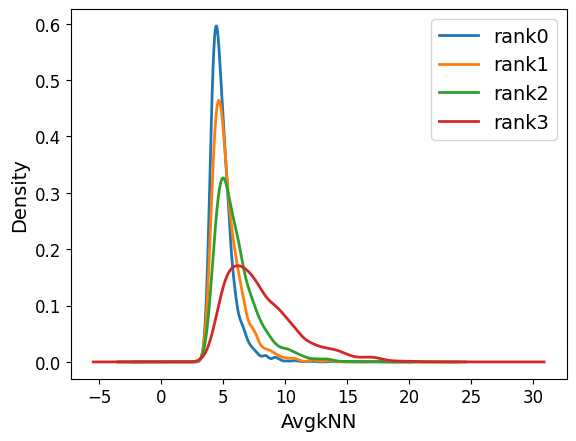

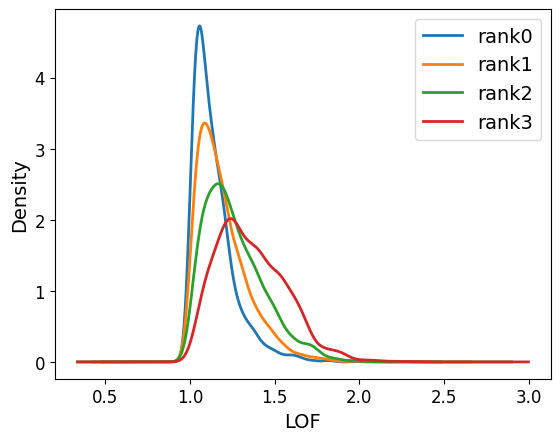

In [ ]:
class_idx = paper_idx[0]
image_path = "out_512_CFG_s/class{}".format(class_idx)
cur_prompt = paper_prompt[0]
try:
    cur_feature_list = torch.load("concate_nv_gap/512_class{}_2.23_0to10000_feature_list.pth".format(class_idx))
    print('the feature list exits')
except:
    print('begin to get features')
    cur_feature_list = get_features(image_path,10000)
    torch.save(cur_feature_list,"concate_nv_gap/512_class{}_2.23_0to10000_feature_list.pth".format(class_idx))

nv_gap_origin = torch.load("concate_nv_gap/512_class{}_2.23_0to10000.pth".format(class_idx),weights_only=True).cpu()
cur_mean_gap = torch.mean(torch.mean(nv_gap_origin,dim=-1),dim=-1)
total_sorted_mean,total_idx_mean = torch.sort(cur_mean_gap,descending=True)
plot_density_with_idx(cur_feature_list,total_idx_mean,score_type='knn',num_layer=4)
plt.show()
plot_density_with_idx(cur_feature_list,total_idx_mean,score_type='LOF',num_layer=4)
plt.show()

In [ ]:
num_images = 10000
for rest1 in tqdm(range(len(paper_idx))):   
    class_idx = paper_idx[rest1]
    image_path = "out_512_CFG_s/class{}".format(class_idx)
    cur_prompt = paper_prompt[rest1]
    try:
        cur_feature_list = torch.load("concate_nv_gap/512_class{}_2.23_0to10000_feature_list.pth".format(class_idx))
        print('the feature list exits')
    except:
        print('begin to get features')
        cur_feature_list = get_features(image_path,num_images)
        torch.save(cur_feature_list,"concate_nv_gap/512_class{}_2.23_0to10000_feature_list.pth".format(class_idx))

    nv_gap_origin = torch.load("concate_nv_gap/512_class{}_2.23_0to10000.pth".format(class_idx),weights_only=True).cpu()
    cur_mean_gap = torch.mean(torch.mean(nv_gap_origin,dim=-1),dim=-1)
    total_sorted_mean,total_idx_mean = torch.sort(cur_mean_gap,descending=True)
    print(class_idx,cur_prompt)
    plot_density_with_idx(cur_feature_list,total_idx_mean,score_type='knn',num_layer=4)
    plt.show()
    plot_density_with_idx(cur_feature_list,total_idx_mean,score_type='LOF',num_layer=4)
    plt.show()